# Data preprocessing

In [12]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
dataset_filename = 'training_set.npz'

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    directory_dataset = '/kaggle/input/blood-cells'
else:
    directory_dataset = '../data'
    if not os.path.exists(directory_dataset):
        os.makedirs(directory_dataset)
    if not os.path.exists(f'{directory_dataset}/{dataset_filename}'):
        url = "https://www.kaggle.com/datasets/camilosinning/blood-cells/download/d8yi67rTZ6HYsohjT9GN%2Fversions%2FFwagJNSFnqnnOYT5wDmO%2Ffiles%2Ftraining_set.npz?datasetVersionNumber=1"
        urllib.request.urlretrieve(url, directory_dataset)

In [ ]:
dataset_path = f'{directory_dataset}/{dataset_filename}'

dataset = np.load(dataset_path,allow_pickle=True)
X = dataset['images']
y = dataset['labels']

In [16]:
X.shape, y.shape

((13759, 96, 96, 3), (13759, 1))

## Data exploration

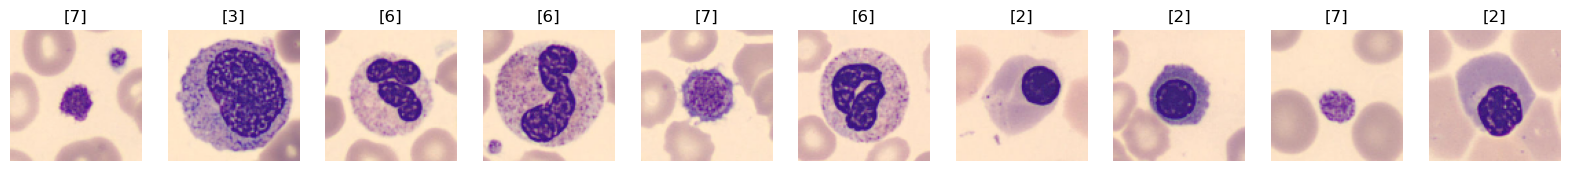

In [17]:
# See the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axes[i].imshow(X[i])
    axes[i].axis('off')
    axes[i].set_title(y[i])
plt.show()

In [18]:
# Print the unique values of the labels
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

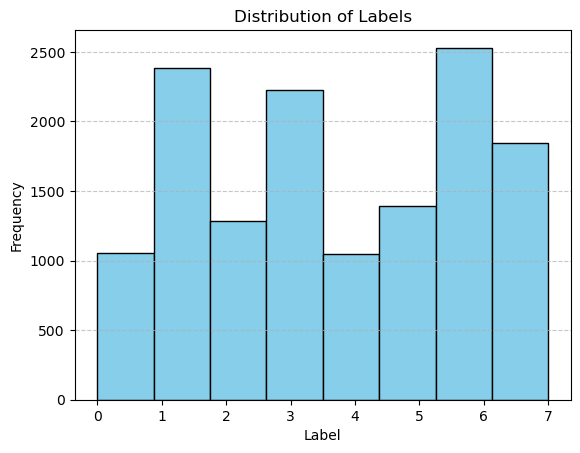

In [23]:
# Plot the distribution of the labels
plt.hist(y, bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

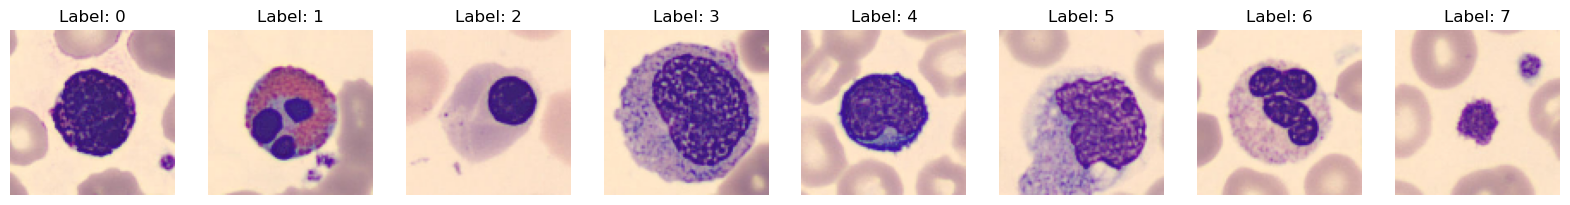

In [25]:
unique_labels = np.unique(y)
fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 5))

for i, label in enumerate(unique_labels):
    index = np.where(y == label)[0][0]
    axes[i].imshow(X[index])
    axes[i].axis('off')
    axes[i].set_title(f'Label: {label}')

plt.show()

## Checking outliers

### PCA

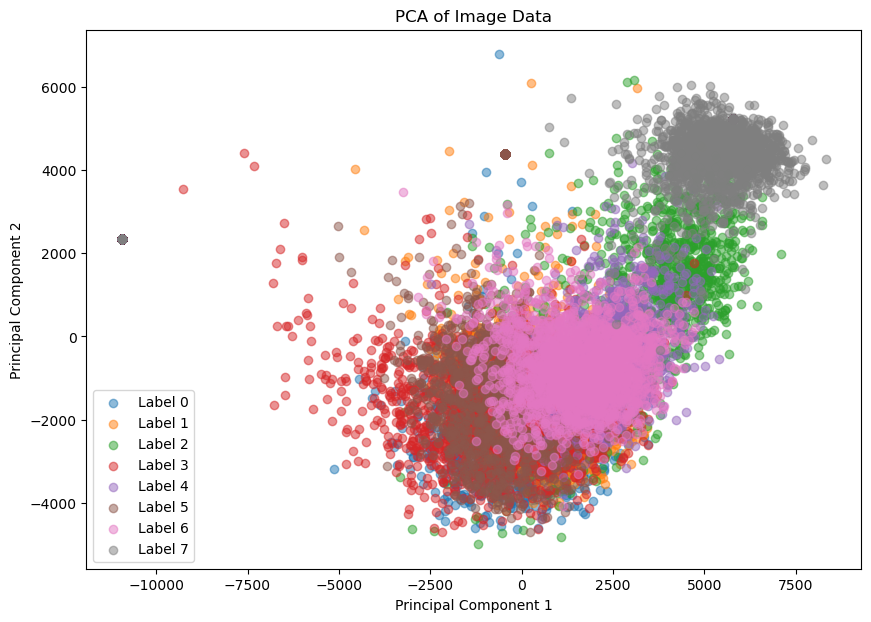

In [26]:
from sklearn.decomposition import PCA

# Flatten the images
X_flattened = X.reshape(X.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flattened)

# Plot the PCA results
plt.figure(figsize=(10, 7))
for label in unique_labels:
    indices = np.where(y == label)
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Label {label}', alpha=0.5)

plt.title('PCA of Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

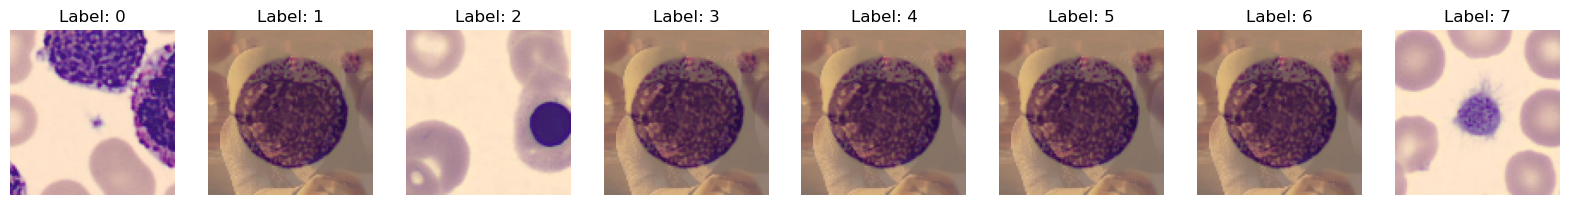

In [49]:
from sklearn.preprocessing import StandardScaler

# Normalize the PCA results
scaler = StandardScaler()
X_pca_normalized = scaler.fit_transform(X_pca)

# Calculate the distance from the origin for each point
distances = np.linalg.norm(X_pca_normalized, axis=1)

# Find the top 5 outliers for each label
outliers = {}
for label in unique_labels:
    label_indices = np.where(y == label)[0]
    label_distances = distances[label_indices]
    top_outliers = label_indices[np.argsort(label_distances)[-5:]]
    outliers[label] = top_outliers

# Plot the outliers
fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 5))
for i, label in enumerate(unique_labels):
    for idx in outliers[label]:
        axes[i].imshow(X[idx])
        axes[i].axis('off')
    axes[i].set_title(f'Label: {label}')

plt.show()

SHERK!!?

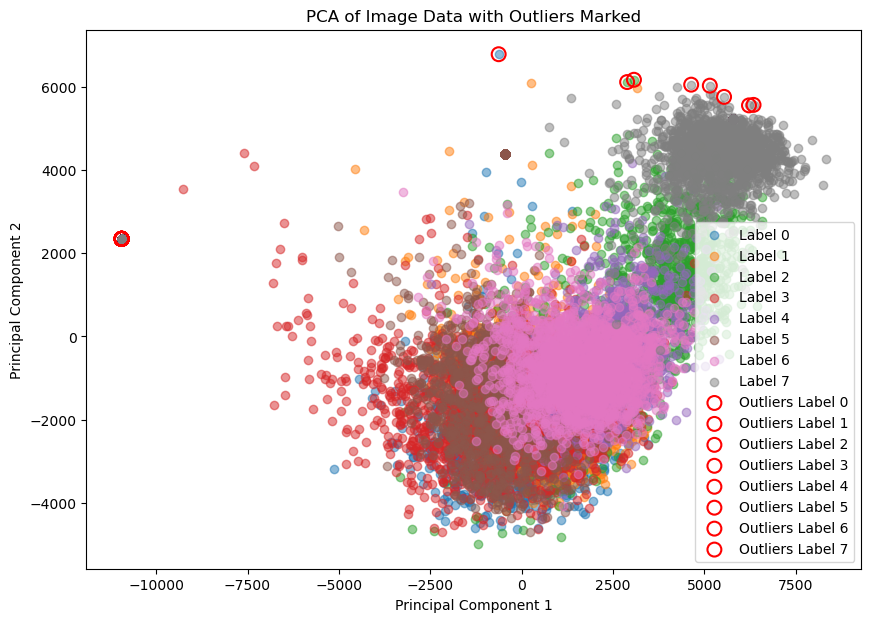

In [52]:
# Plot the PCA results with outliers marked
plt.figure(figsize=(10, 7))
for label in unique_labels:
    indices = np.where(y == label)
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Label {label}', alpha=0.5)

# Mark the outliers
for label, outlier_indices in outliers.items():
    plt.scatter(X_pca[outlier_indices, 0], X_pca[outlier_indices, 1], edgecolor='red', facecolor='none', s=100, linewidth=1.5, label=f'Outliers Label {label}')

plt.title('PCA of Image Data with Outliers Marked')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

C:\Users\camil\AppData\Local\Temp\ipykernel_20940\3147151716.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


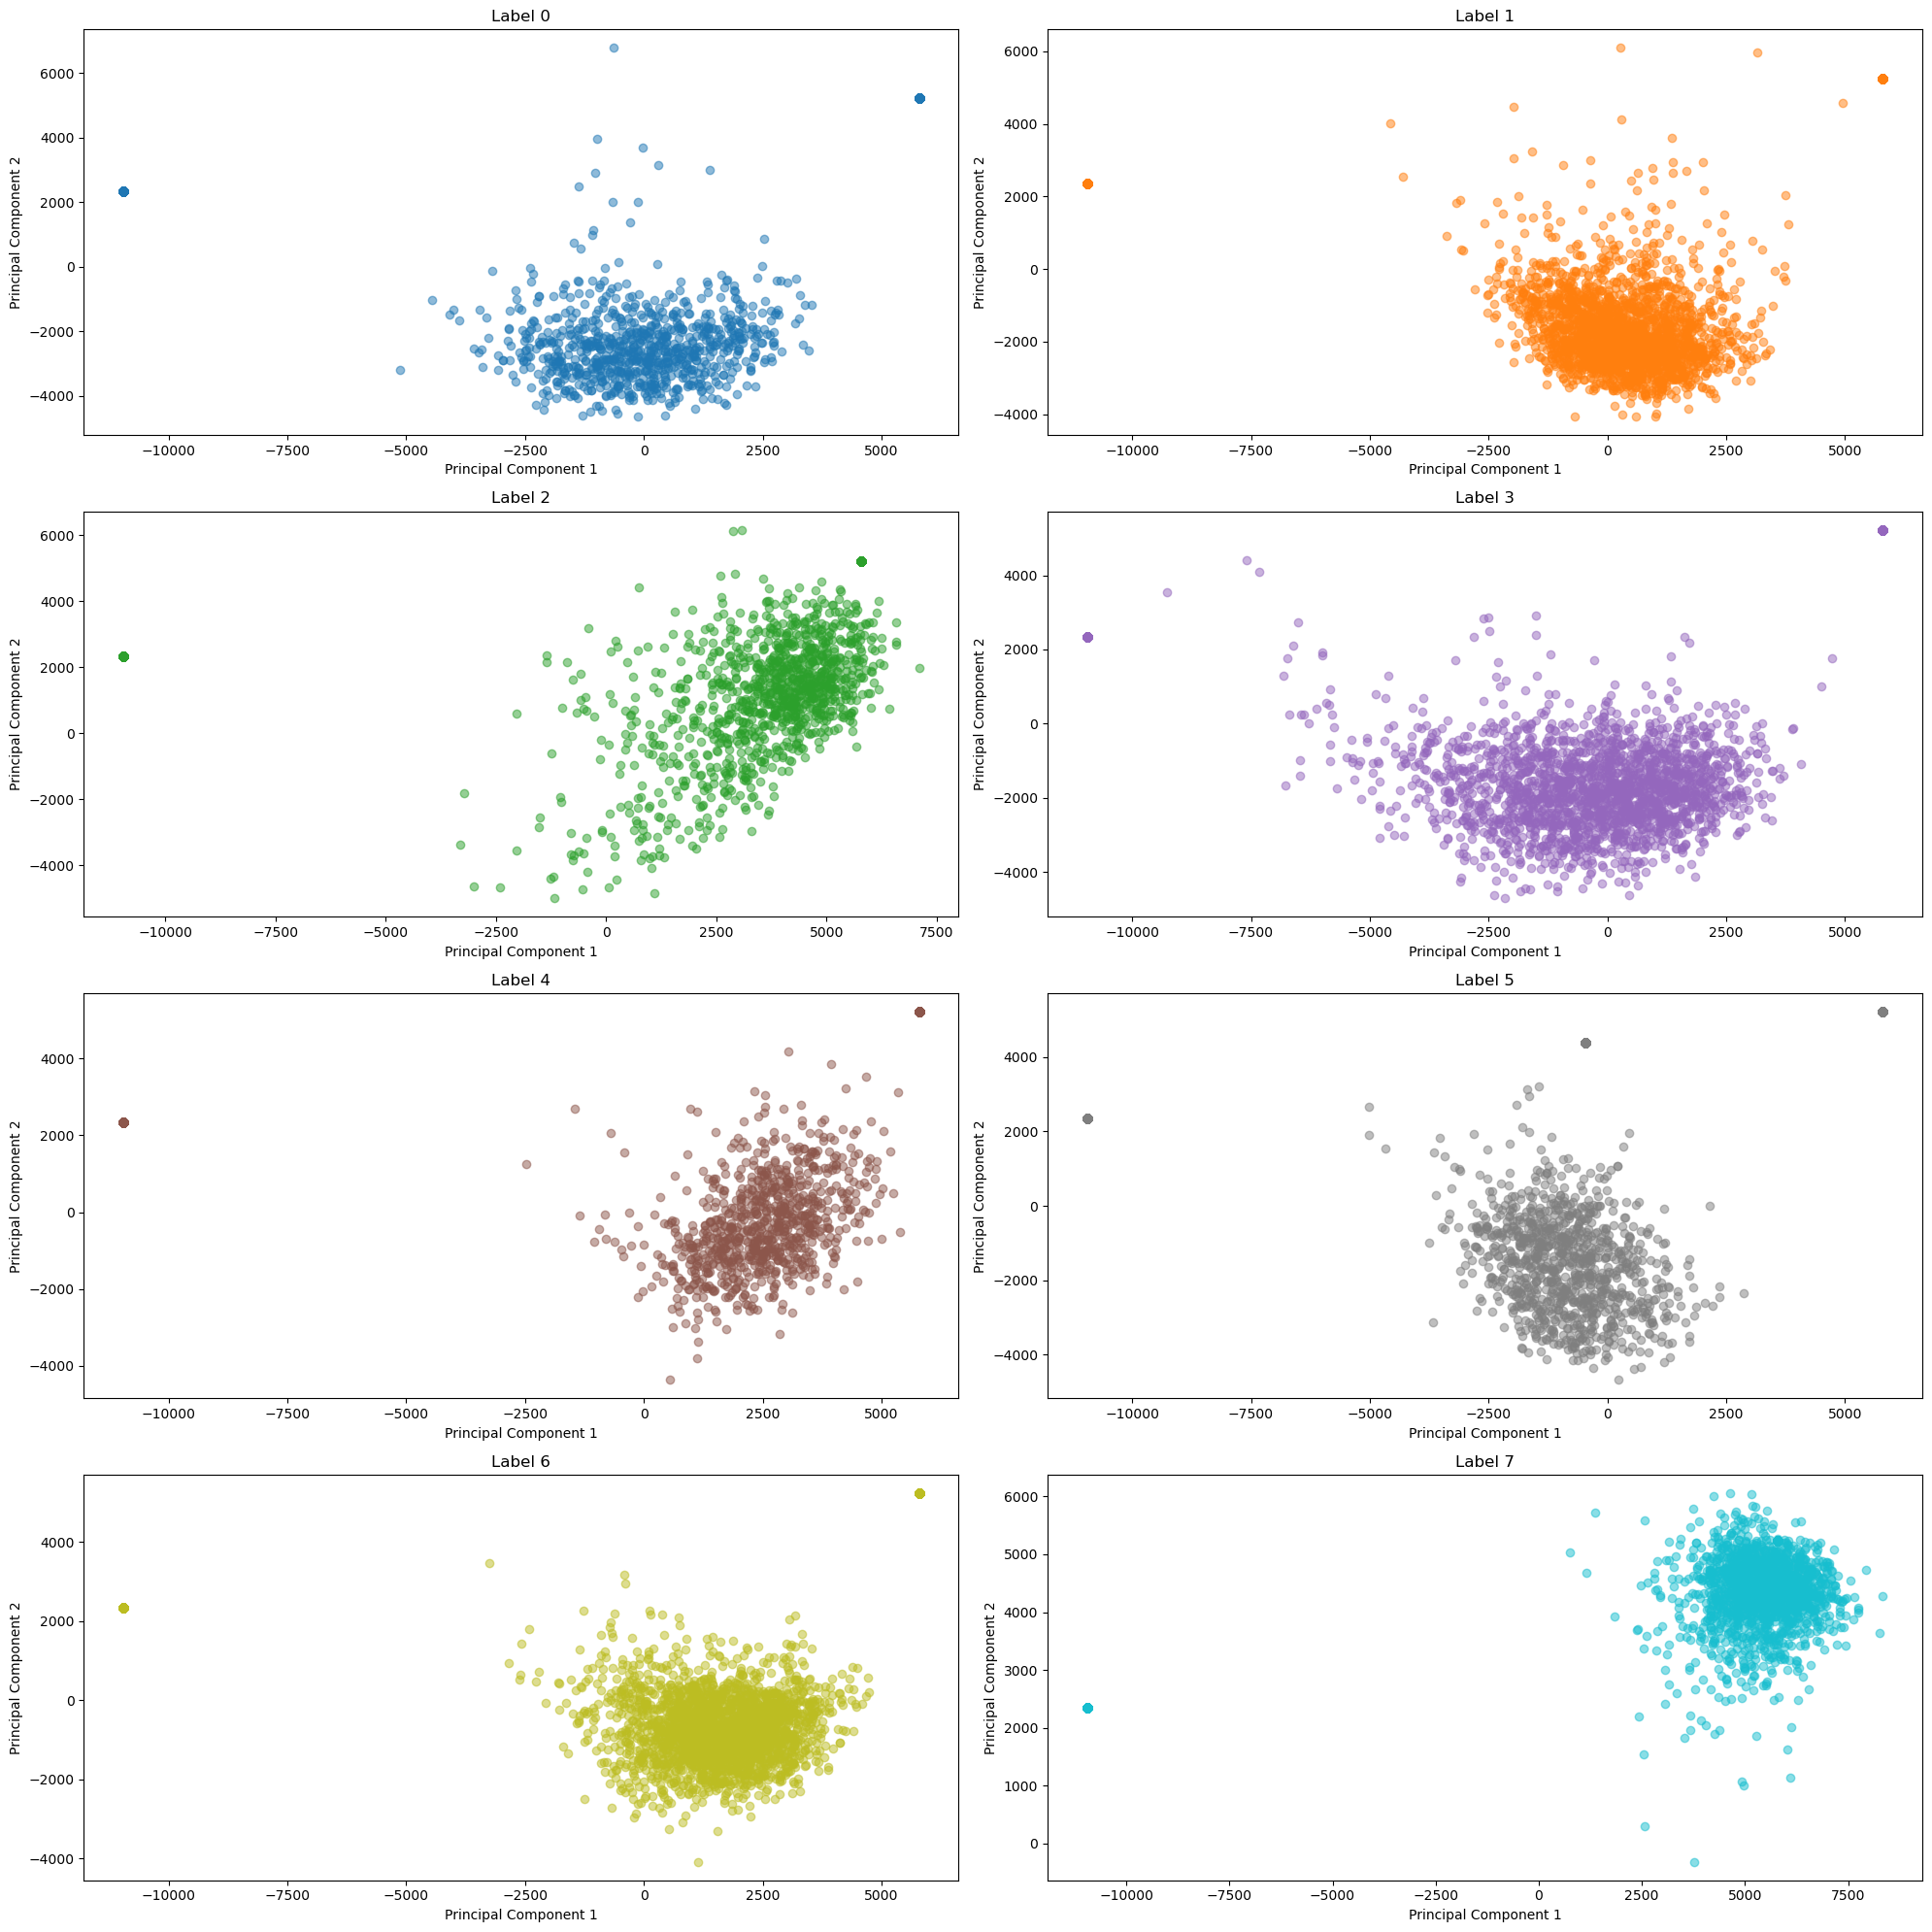

In [61]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    row, col = divmod(i, 2)
    indices = np.where(y == label)
    axes[row, col].scatter(X_pca[indices, 0], X_pca[indices, 1], alpha=0.5, color=colors(i))
    axes[row, col].set_title(f'Label {label}')
    axes[row, col].set_xlabel('Principal Component 1')
    axes[row, col].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

NameError: name 'X_tsne' is not defined

## T-SNE

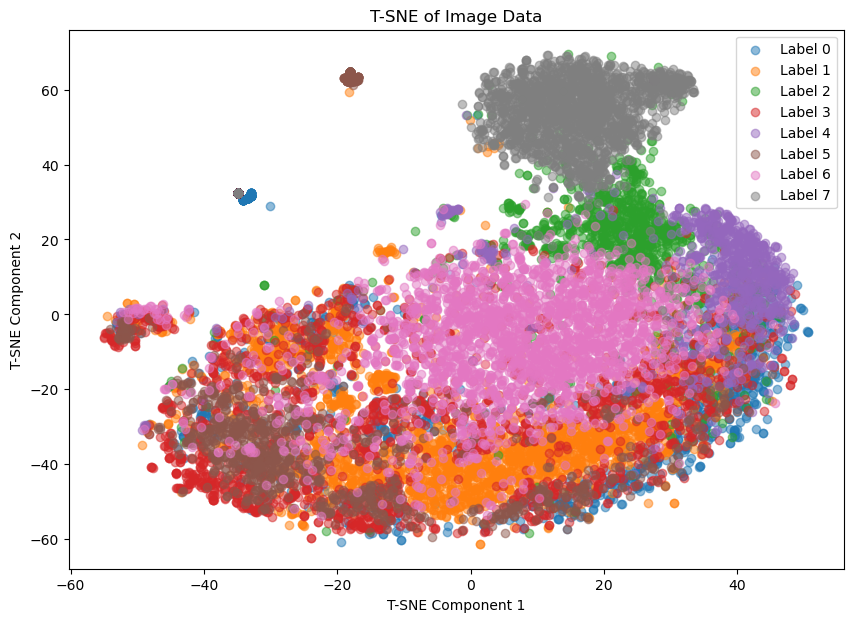

In [53]:
from sklearn.manifold import TSNE

# Apply T-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_flattened)

# Plot the T-SNE results
plt.figure(figsize=(10, 7))
for label in unique_labels:
    indices = np.where(y == label)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Label {label}', alpha=0.5)

plt.title('T-SNE of Image Data')
plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.legend()
plt.show()

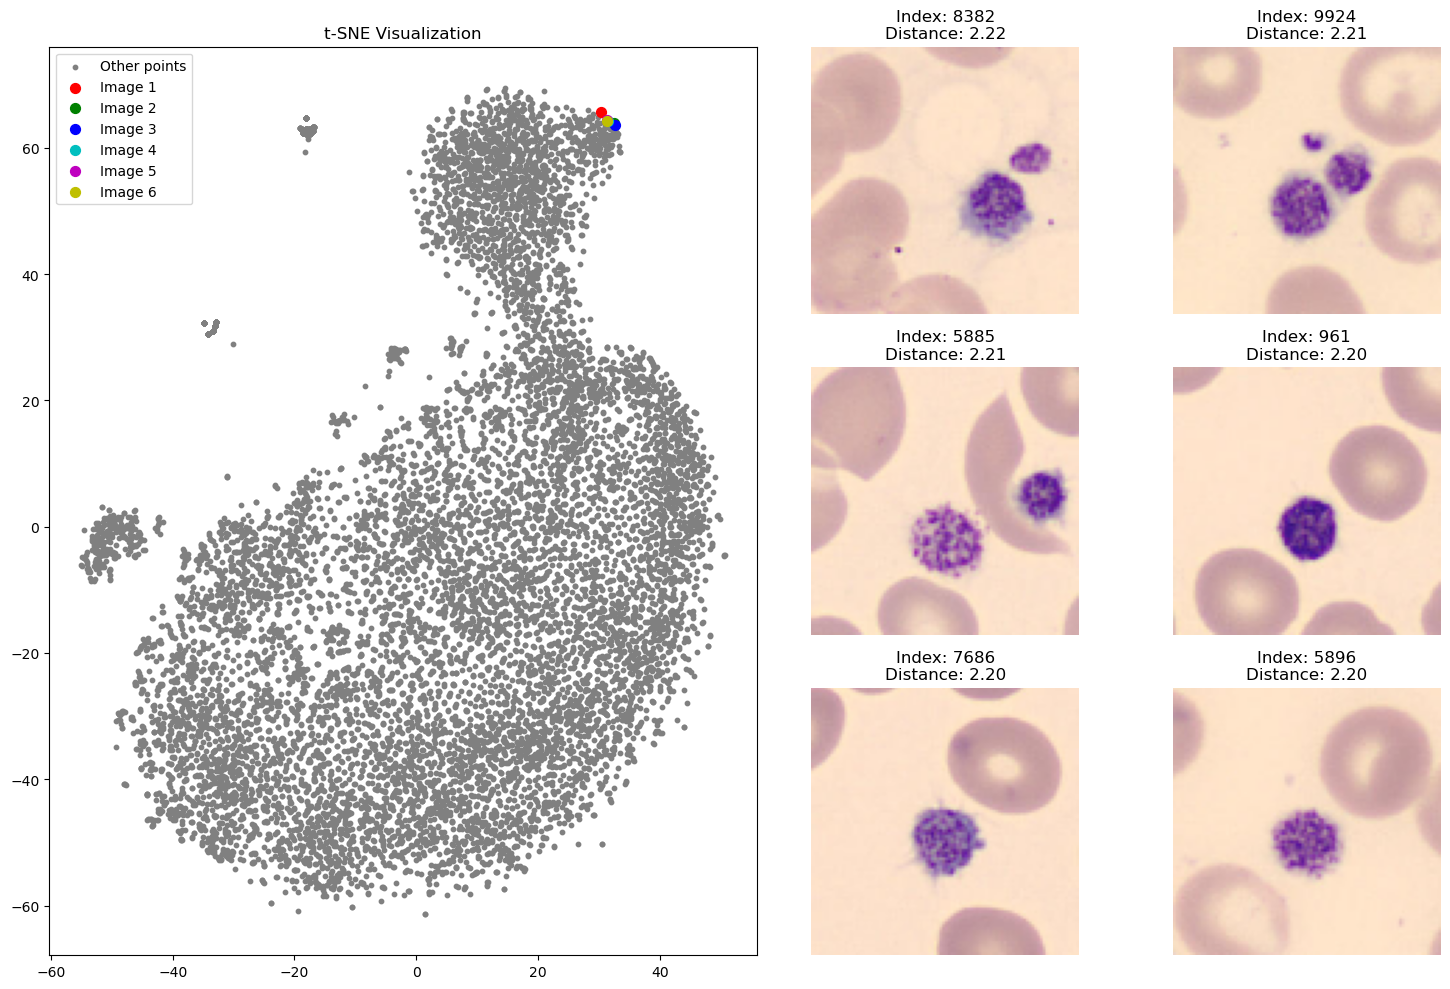

In [60]:
from scipy.spatial import distance
from matplotlib.gridspec import GridSpec
import hashlib

# Function to hash images for detecting duplicates
def hash_image(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Find outliers
mahalanobis_distances = [distance.mahalanobis(x, np.mean(X_tsne,axis=0), np.linalg.inv(np.cov(X_tsne.T))) for x in X_tsne]
out = np.where(np.array(mahalanobis_distances) >= 2.5)[0]

# Visualize outliers
uniq = np.unique(X[out],axis=0)


# Find indices of the images with the largest Mahalanobis distances
highest_distance_indices = np.argsort(mahalanobis_distances)[::-1]

# Filter out duplicates based on image hashes
unique_images = []
unique_indices = []
for idx in highest_distance_indices:
    img_hash = hash_image(X[idx])
    if img_hash not in unique_images:
        unique_images.append(img_hash)
        unique_indices.append(idx)
    if len(unique_indices) >= 6:  # Limit to 6 unique images
        break

# Create a figure for the plot and images
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(3, 4, figure=fig)  # Create a grid spec with 3 rows, 4 columns

# Define a colormap for differentiating image points on the t-SNE plot
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot the t-SNE visualization (spanning the entire left side, i.e., first 3 rows of the first column)
ax_tsne = fig.add_subplot(gs[:, :2])  # Large t-SNE plot (3 rows, 2 columns)
ax_tsne.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, c='gray', label="Other points")
ax_tsne.set_title('t-SNE Visualization')

# Plot the 6 unique images with the highest Mahalanobis distances on the right (spanning 3 rows, 2 columns)
for i, idx in enumerate(unique_indices):
    ax_img = fig.add_subplot(gs[i // 2, 2 + i % 2])  # Create the subplots for images on the right side
    ax_img.imshow(np.clip(X[idx], 0, 255))
    ax_img.axis('off')
    ax_img.set_title(f"Index: {idx}\nDistance: {mahalanobis_distances[idx]:.2f}")

    # Highlight the corresponding point on the t-SNE plot with different colors
    ax_tsne.scatter(X_tsne[idx, 0], X_tsne[idx, 1], s=50, c=colors[i], marker='o', label=f"Image {i+1}")

# Add a legend to the t-SNE plot for the highlighted images
ax_tsne.legend()

plt.tight_layout()
plt.show()